# Set Up

In [1]:
import os, pandas as pd, numpy as np

from mtgf.scryfall import search_all
from mtgf.pd.defaults import RELEVANT_COLUMNS
from mtgf.pd.utils import planeswalker_names_from_type, filter_df_for_planeswalker

# Fetch data from Scryfall

In [2]:
q1 = 'type:planeswalker'                # Oathbreakers are commanders
q2 = '-type:creature'                   # the transform Planeswalkers are not allowed
q3 = '-name:"Saheeli, the Gifted"'      # this Planeswalker is banned in Oathbreaker
q4 = '-name:"Urza, Academy Headmaster"' # this Planeswalker is from an unset and is not legal in the format
q5 = '-is:planeswalkerdeck'             # some people greatly dislike the Planeswalkers from the Planeswalker decks
query = ' '.join([q1,q2,q3,q4,q5])      # join the query together
r = search_all(params={'q': query})     # fetch request

In [3]:
# construct DataFrame from Scryfall Card Objects, filtering out irrelvant information
df = pd.DataFrame(r).filter(items=RELEVANT_COLUMNS)

In [4]:
df.head()

name  mana_cost  cmc  \
0  Ajani, Adversary of Tyrants  {2}{W}{W}  4.0   
1   Ajani, Caller of the Pride  {1}{W}{W}  3.0   
2               Ajani Goldmane  {2}{W}{W}  4.0   
3      Ajani, Mentor of Heroes  {3}{G}{W}  5.0   
4              Ajani Steadfast     {3}{W}  4.0   

                        type_line  \
0  Legendary Planeswalker — Ajani   
1  Legendary Planeswalker — Ajani   
2  Legendary Planeswalker — Ajani   
3  Legendary Planeswalker — Ajani   
4  Legendary Planeswalker — Ajani   

                                         oracle_text loyalty  colors  \
0  +1: Put a +1/+1 counter on each of up to two t...       4     [W]   
1  +1: Put a +1/+1 counter on up to one target cr...       4     [W]   
2  +1: You gain 2 life.\n−1: Put a +1/+1 counter ...       4     [W]   
3  +1: Distribute three +1/+1 counters among one,...       4  [G, W]   
4  +1: Until end of turn, up to one target creatu...       4     [W]   

  color_identity  rarity  edhrec_rank  
0            [W]  mythic         4949  
1            [W]  mythic         2060  
2            [W]  mythic         2599  
3         [G, W]  mythic         1553  
4            [W]  mythic         1494

# Get the name of the Planeswalkers|

In [5]:
planeswalkers = planeswalker_names_from_type(df)
planeswalkers[:10]

['Ajani',
 'Aminatou',
 'Angrath',
 'Arlinn',
 'Ashiok',
 'Chandra',
 'Dack',
 'Daretti',
 'Davriel',
 'Domri']

## Variants of each Planeswalker

In [6]:
import seaborn as sns, matplotlib.pyplot as plt
from mtgf.settings import IMG_DIR

In [7]:
# Tally each filtered DataFrame for the number of variants each Planeswalker has
res = []
for pw in planeswalkers:
    res.append({"amount": len(filter_df_for_planeswalker(df, pw)), "planeswalker": pw})
    
plot_df = pd.DataFrame(res).sort_values(by=['amount'], ascending=False)

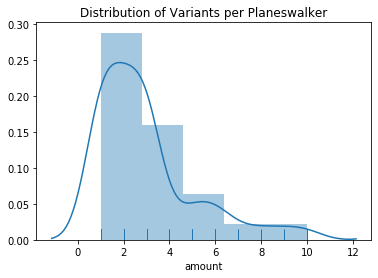

In [8]:
# Plot the distribution of variants per Planeswalker
sns_plot = sns.distplot(plot_df.amount, kde=True, rug=True, bins=5);
sns_plot.set_title('Distribution of Variants per Planeswalker')
plt.savefig(os.path.join(IMG_DIR, 'oathbreaker_overlap', 'dist_of_pws.png'))

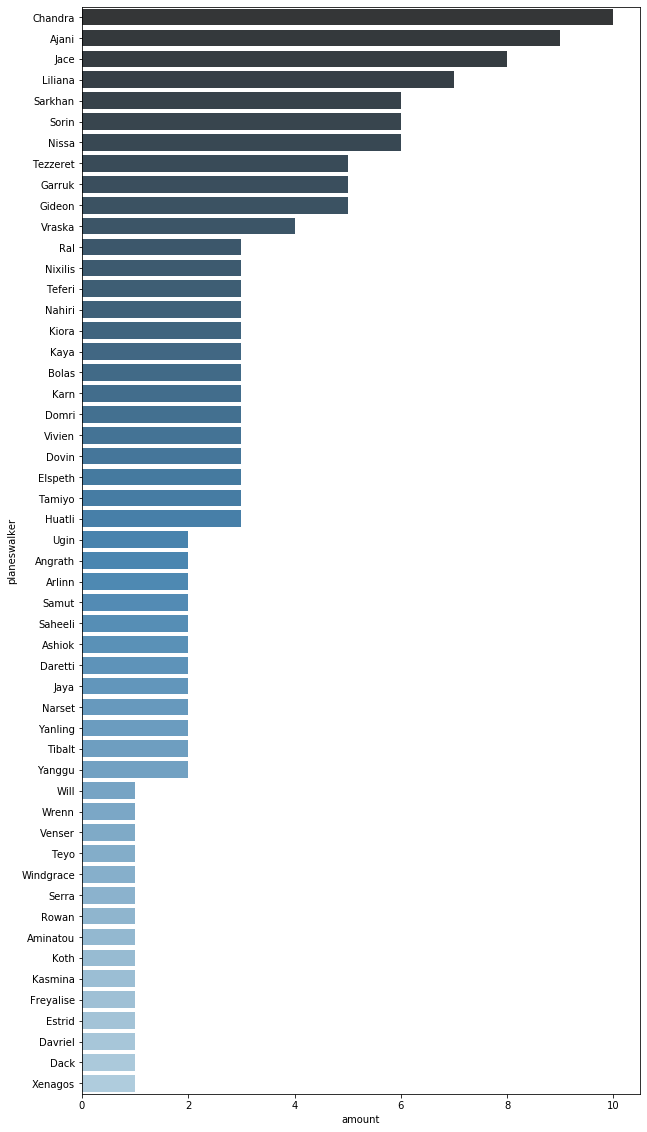

In [9]:
# Plot the count of the number of variants per Planeswalker
plt.figure(figsize=(10, 20))
sns_plot = sns.barplot(y="planeswalker", x="amount", data=plot_df, palette="Blues_d")
plt.savefig(os.path.join(IMG_DIR, 'oathbreaker_overlap', 'number_of_pws.png'))

## Word occurence
For a step by step breakdown of what happens under the hood, check out the [walkthrough](https://gitlab.com/SumNeuron/mtgf/blob/master/markdown/light-textual-analysis-walkthrough.md)

In [10]:
from mtgf.pd.words import top_words_occurrences

In [11]:
planeswalker = 'Ajani'
filtered = filter_df_for_planeswalker(df, planeswalker)
threshold = 0.33
words = top_words_occurrences(filtered, threshold)

In [12]:
from mtgf.pd.words import to_word_coo
from mtgf.pd.plots import word_occurrence_heatmap

<Figure size 432x288 with 0 Axes>

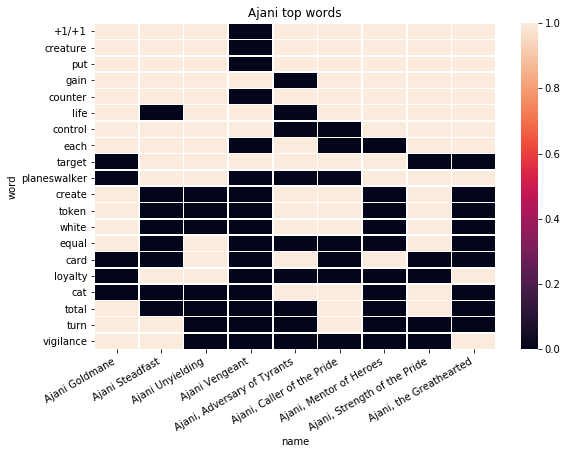

In [13]:
f, ax, plt = word_occurrence_heatmap(to_word_coo(filtered, words))
ax.set_title('{} top words'.format(planeswalker));

## Make images
Here we have threshold set to 0.33 to make more legible heatmaps

In [14]:
import matplotlib

threshold = 0.33
for planeswalker in planeswalkers:
    filtered = filter_df_for_planeswalker(df, planeswalker)
    words = top_words_occurrences(filtered, threshold)
    f, ax, plt = word_occurrence_heatmap(to_word_coo(filtered, words))
    ax.set_title('{} top words'.format(planeswalker))
    plt.savefig(
        os.path.join(
            IMG_DIR, 
            'oathbreaker_overlap', 
            'heatmaps',
            '{}_heatmap_threshold_{}.png'.format(planeswalker, threshold)
        )
    )   
    matplotlib.pyplot.close('all')

## Calculate adjusted number of Planeswalkers
Here we set threshold to 0.0 to take all words into account

In [15]:
from mtgf.pd.words import word_density

In [16]:
results = []
threshold = 0.
for planeswalker in planeswalkers:
    filtered = filter_df_for_planeswalker(df, planeswalker)
    words = top_words_occurrences(filtered, threshold)
    density = word_density(filtered, words)
    results.append((planeswalker, len(filtered), density))    

Since density (the percent of the word matrix which is full) tells us how many Planeswalkers are similar due to overlapping design space, $len(filtered) - len(filtered) * density + 1$ tells us how many Planeswalkers are unique. 

Where $len(filtered) * density$ is again _all_ of the overlapping Planeswalkers and $+1$ accounts for the fact that even though they all overlap, at least _one_ of them can be considered unique.

In [17]:
nums = []
for pw, n_variants, density in results:
    nums.append(n_variants - n_variants * density + 1)

In [18]:
sum(nums), len(df)

(125.91602337818132, 153)

If one is concerned that the $+ 1$ might somehow inflate the number of variants above the original, we can check for that

In [19]:
for pw, n_variants, density in results:
    adjusted = n_variants - n_variants * density + 1
    if adjusted > n_variants:
        print(pw)

Since The Wanderer does not have a subtype, we need to remember to add 1 to our results

In [21]:
adjusted_number_of_planeswalkers = sum(nums)+1
number_of_overlapping_planeswalkers = len(df) - adjusted_number_of_planeswalkers

In [22]:
adjusted_number_of_planeswalkers, number_of_overlapping_planeswalkers

(126.91602337818132, 26.083976621818678)